## Group 3 - Project 2
# Online Shopper Purchase Prediction

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import model as Group3Models
from math import sin, pi
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression

### Read in CSV

In [2]:
"""Sakar, C. & Kastro, Y. (2018). Online Shoppers Purchasing Intention Dataset [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5F88Q. https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset"""

import model as Group3Models

import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier



In [3]:
#Read in CSV
online_shopping_df = pd.read_csv('online_shoppers_intention.csv')

online_shopping_df.info()

online_shopping_df["Revenue"].value_counts()

# online_shopping_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

Revenue
False    10422
True      1908
Name: count, dtype: int64

### Visualize Distributions for EDA

In [4]:
online_shopping_df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [5]:
online_shopping_df_without_strings = online_shopping_df.copy()
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'June': 6, 
          'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
online_shopping_df_without_strings["Month"] = online_shopping_df_without_strings["Month"].map(months)

visitor = {'New_Visitor': 1, 'Returning_Visitor': 2, 'Other': 3}
online_shopping_df_without_strings["VisitorType"] = online_shopping_df_without_strings["VisitorType"].map(visitor)

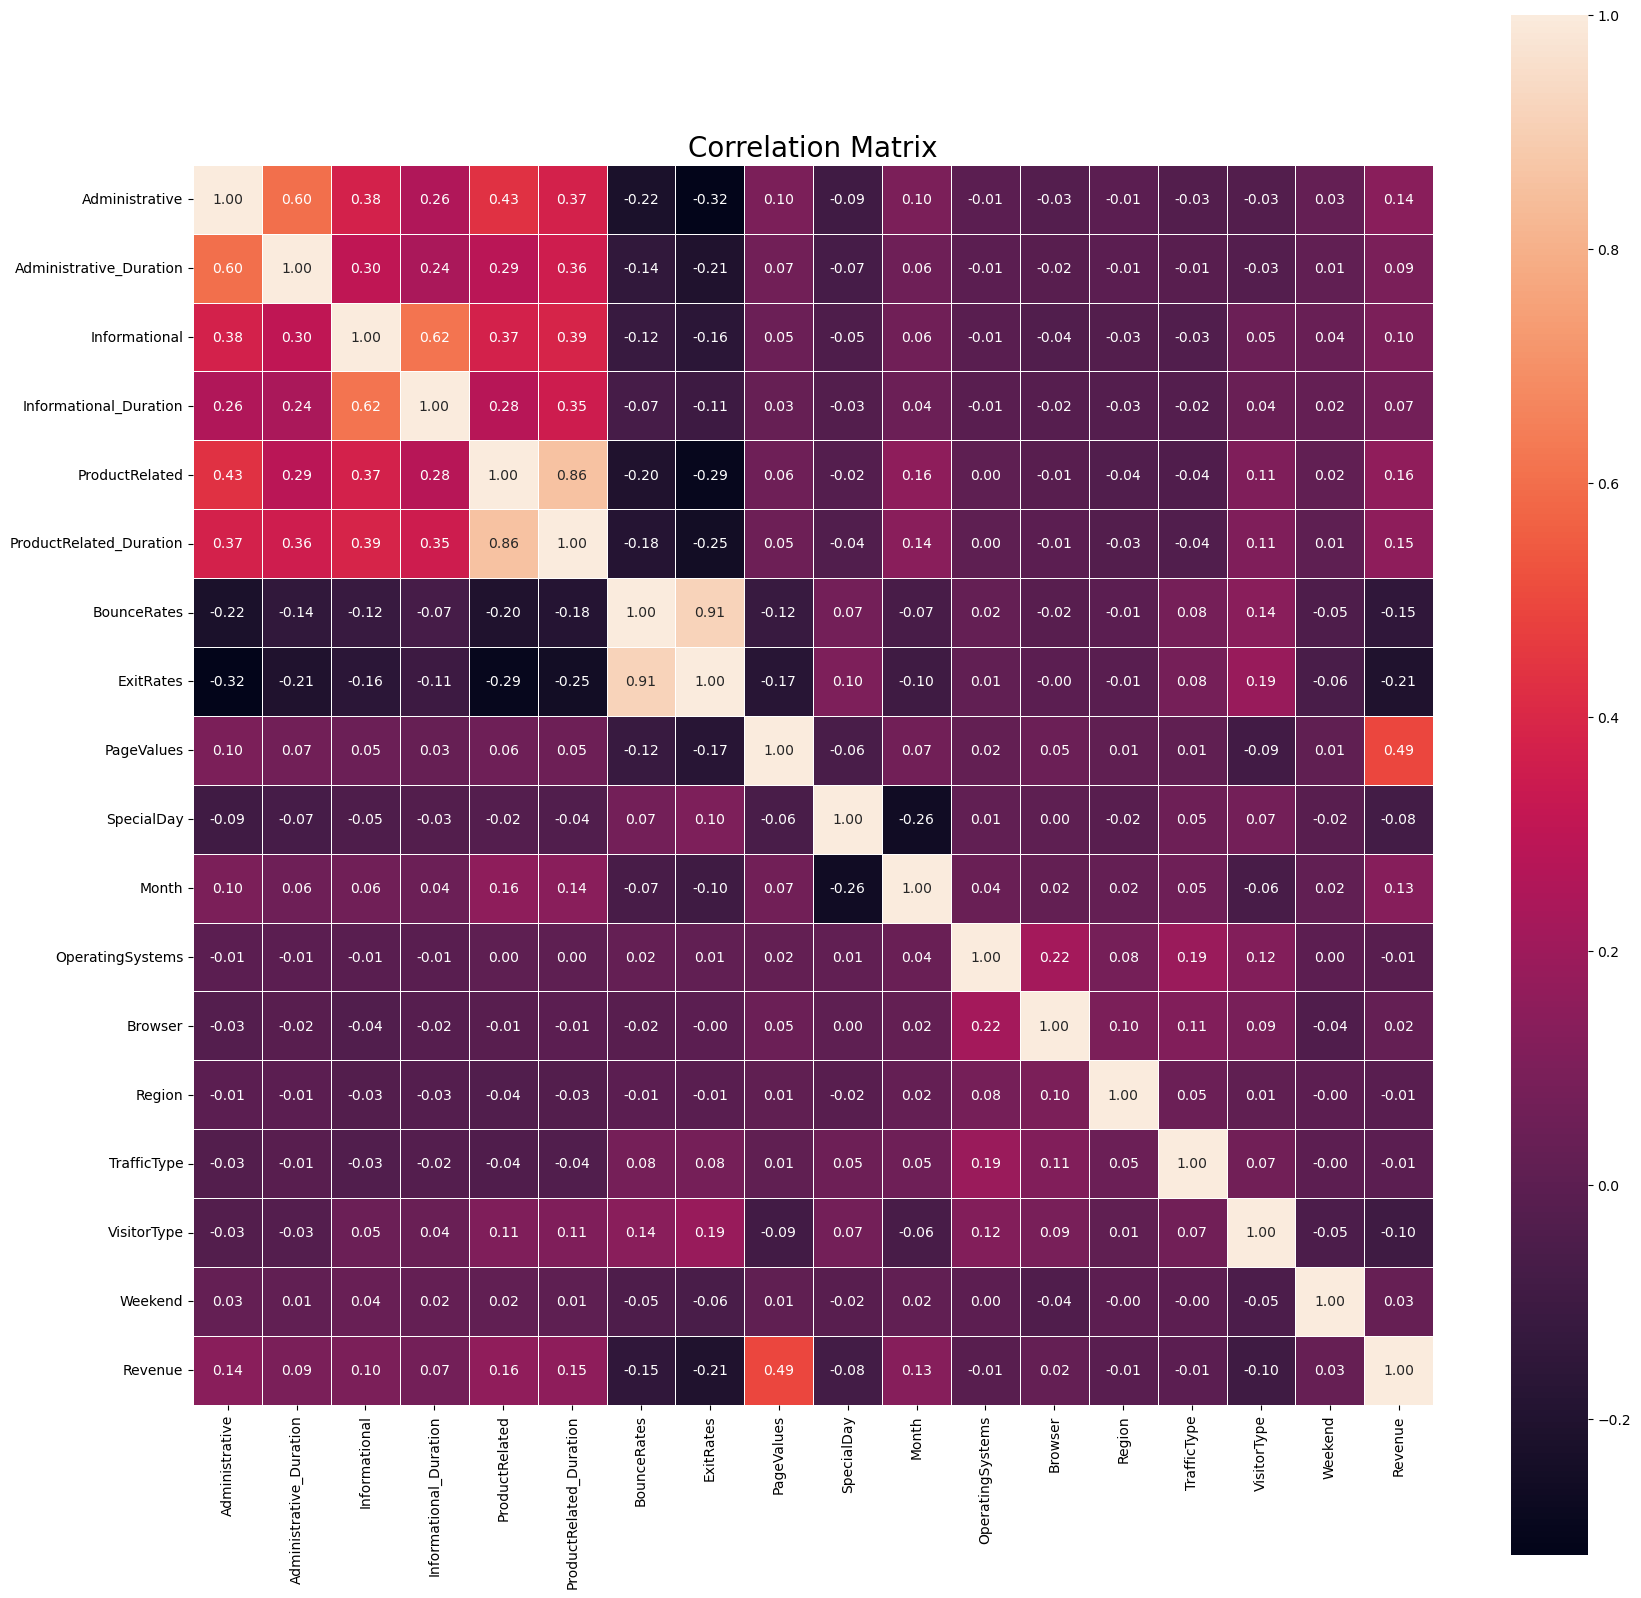

In [6]:
plt.figure()
corr_map = sns.heatmap(data=online_shopping_df_without_strings.corr(), annot=True, square=True, cbar_kws={"shrink": .8}, fmt='.2f', linewidths=.5)
corr_map.figure.set_size_inches(20, 25)
plt.title('Correlation Matrix', fontsize=20)
plt.show()

### Split data into training and test sets

In [7]:
#Drop the target column, setup X and y datasets for train test split
X = online_shopping_df.drop('Revenue', axis=1)
y = online_shopping_df['Revenue']

# Set seed for reproducibility
SEED = 42

#Train Test Split
X_test, X_train, y_test, y_train = train_test_split(X, y, random_state=SEED)

### Scale and Encode Feature Columns

In [8]:
# Separate numerical and categorical columns
num_cols = ['PageValues', 'BounceRates', 'ExitRates']
cat_cols = ['VisitorType', 'Month']

# Scale numerical columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])  # Fit on training data
X_test[num_cols] = scaler.transform(X_test[num_cols])  # Transform using training data parameters

# One-hot encode categorical columns
X_train = pd.get_dummies(X_train, columns=cat_cols)
X_test = pd.get_dummies(X_test, columns=cat_cols)  # Ensure consistent columns with X_train

# Binary columns (Revenue, Weekend) remain the same


In [9]:
# # Initialize the OrdinalEncoder and MinMaxScaler
# ordinal_encoder = OrdinalEncoder()
# min_max_scaler = MinMaxScaler()

# #Change Column to values created by encoder and scale them with the min max scaler
# X_train['VisitorType'] = ordinal_encoder.fit_transform(X_train['VisitorType'].values.reshape(-1, 1))
# X_train['VisitorType'] = min_max_scaler.fit_transform(X_train['VisitorType'].values.reshape(-1, 1))

# ordinal_encoder = OrdinalEncoder()
# min_max_scaler = MinMaxScaler()

# X_train['Month'] = X_train['Month'].apply(lambda x: sin(x*(pi * 6)))

# # Fit and transform the 'VisitorType' column with OrdinalEncoder
# X_train['Month'] = ordinal_encoder.fit_transform(X_train['Month'].values.reshape(-1, 1))

# # Now scale the encoded values to [0, 1] using MinMaxScaler
# X_train['Month'] = min_max_scaler.fit_transform(X_train['Month'].values.reshape(-1, 1))

# # Check the unique values after scaling
# print(X_train['Month'].value_counts())

### Use SMOTEEN to oversample and balance the classes

In [10]:
#SMOTEEN the X_train, y_train to balance the classes
smote = SMOTEENN(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

### Create report on model performances

#### XGBoost_V1

Accuracy Score: 0.8943441116037634
Balanced Accuracy Score: 0.7633493345115905
              precision    recall  f1-score   support

       False       0.93      0.95      0.94      7828
        True       0.69      0.57      0.63      1419

    accuracy                           0.89      9247
   macro avg       0.81      0.76      0.78      9247
weighted avg       0.89      0.89      0.89      9247



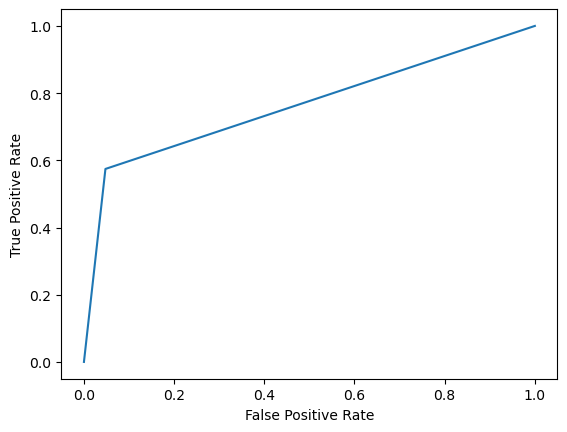

AUC Score: 0.7633493345115904


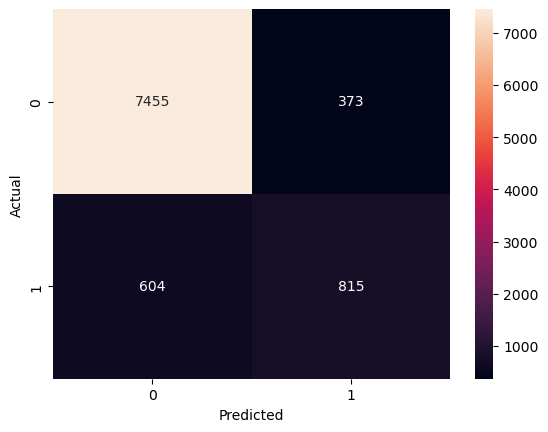

Large gap in score means overfitting: 
1.0
0.8943441116037634


In [11]:
#Without SMOTEEN
model = Group3Models.model_xgboost_V1(X_train, y_train)
Group3Models.evaluate_model(model, X_train, X_test, y_train, y_test)

Accuracy Score: 0.8739050502865794
Balanced Accuracy Score: 0.8355156477371306
              precision    recall  f1-score   support

       False       0.96      0.89      0.92      7828
        True       0.56      0.78      0.66      1419

    accuracy                           0.87      9247
   macro avg       0.76      0.84      0.79      9247
weighted avg       0.90      0.87      0.88      9247



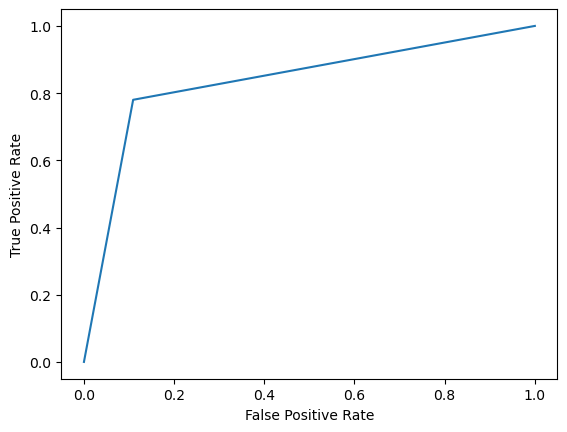

AUC Score: 0.8355156477371305


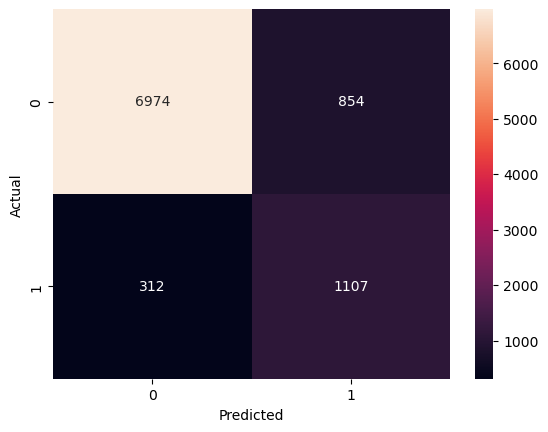

Large gap in score means overfitting: 
1.0
0.8739050502865794


In [12]:
model = Group3Models.model_xgboost_V1(X_train_bal, y_train_bal)
Group3Models.evaluate_model(model, X_train_bal, X_test, y_train_bal, y_test)

#### XGBoost_V2

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.895 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.880 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.893 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.893 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.893 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.888 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.882 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_dept

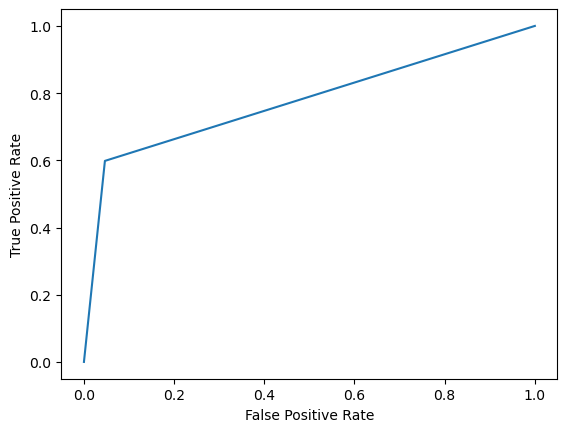

AUC Score: 0.7759044617846057


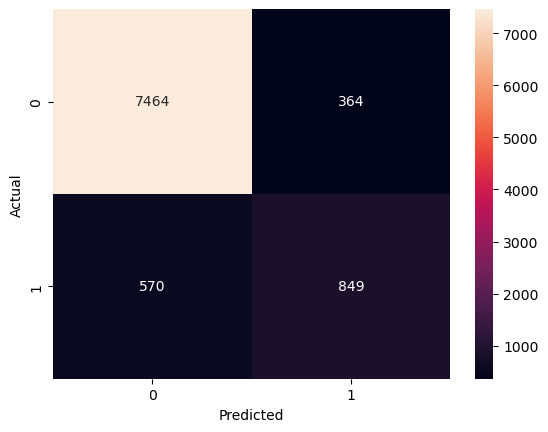

Large gap in score means overfitting: 
0.9354524813493351
0.8989942684113766


In [13]:
#Without SMOTEEN
model = Group3Models.model_xgboost_V2(X_train, y_train)
Group3Models.evaluate_model(model, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.872 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.976 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.968 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.968 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.965 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.873 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.973 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_dept

c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


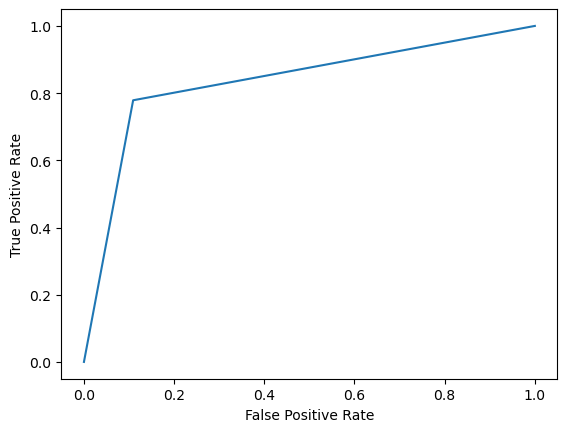

AUC Score: 0.8348109261021763


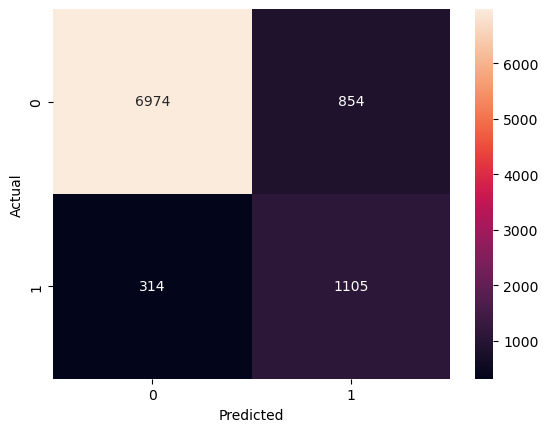

Large gap in score means overfitting: 
0.9993894993894994
0.8736887639234346


In [14]:
model = Group3Models.model_xgboost_V2(X_train_bal, y_train_bal)
Group3Models.evaluate_model(model, X_train_bal, X_test, y_train_bal, y_test)

#### XGBoost_V3

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.896 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.870 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.888 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.901 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.904 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=1, subsample=0.6;, score=0.900 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=1, subsample=0.6;, score=0.882 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_chil

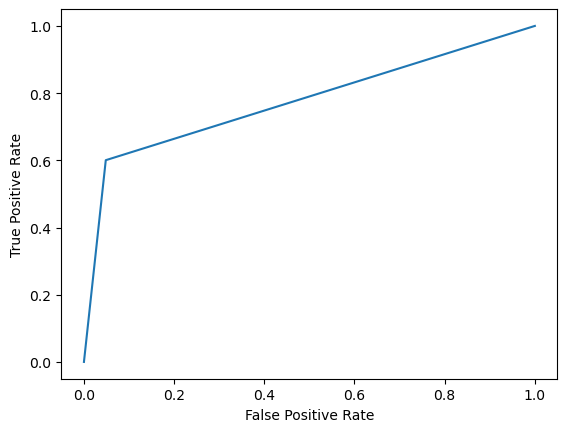

AUC Score: 0.7760034451057137


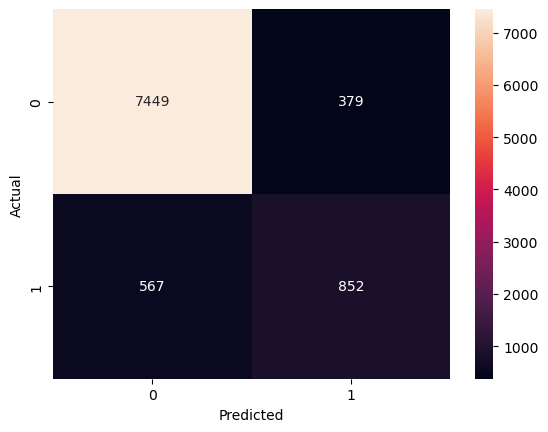

Large gap in score means overfitting: 
0.9416153097632176
0.8976965502325078


In [15]:
#Without SMOTEEN
model = Group3Models.model_xgboost_V3(X_train, y_train)
Group3Models.evaluate_model(model, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, subsample=0.8;, score=0.873 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, subsample=0.8;, score=0.979 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, subsample=0.8;, score=0.965 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, subsample=0.8;, score=0.963 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, subsample=0.8;, score=0.963 total time=   0.0s
[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=1, subsample=0.6;, score=0.866 total time=   0.0s
[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=1, subsample=0.6;, score=0.979 total time=   0.0s
[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=4,

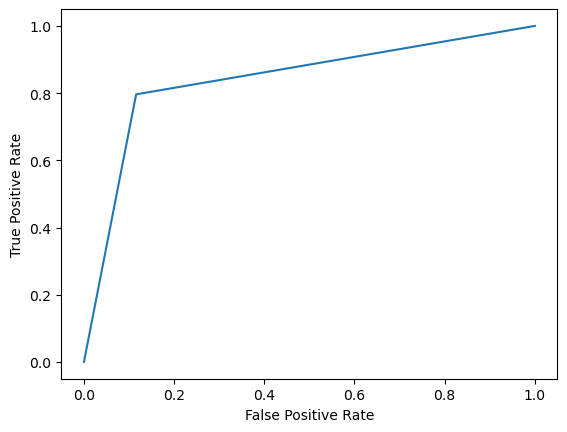

AUC Score: 0.8402985362171824


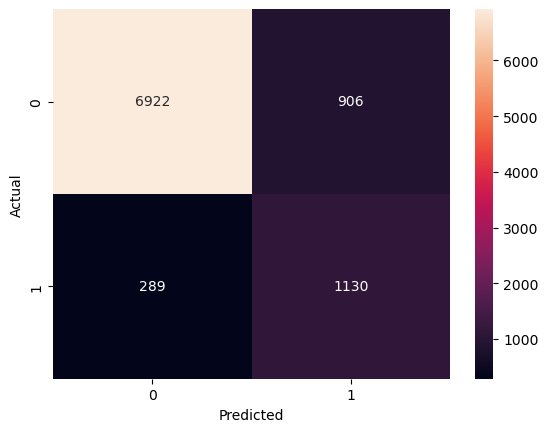

Large gap in score means overfitting: 
0.9862637362637363
0.8707688980209798


In [16]:
model = Group3Models.model_xgboost_V3(X_train_bal, y_train_bal)
Group3Models.evaluate_model(model, X_train_bal, X_test, y_train_bal, y_test)

#### ADABoost_V1

c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy Score: 0.888612522980426
Balanced Accuracy Score: 0.7550597626993035
              precision    recall  f1-score   support

       False       0.92      0.95      0.94      7828
        True       0.66      0.56      0.61      1419

    accuracy                           0.89      9247
   macro avg       0.79      0.76      0.77      9247
weighted avg       0.88      0.89      0.88      9247



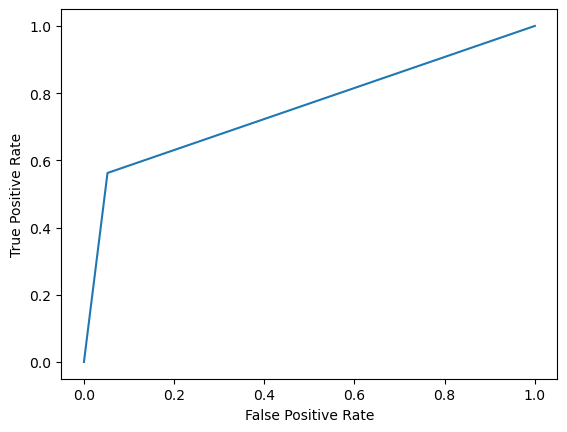

AUC Score: 0.7550597626993035


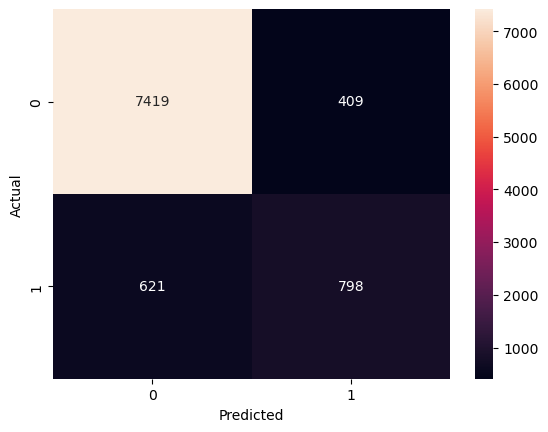

Large gap in score means overfitting: 
0.8958806357444048
0.888612522980426


In [17]:
#Without SMOTEEN
model = Group3Models.model_adaboost_V1(X_train, y_train)
Group3Models.evaluate_model(model, X_train, X_test, y_train, y_test)

c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy Score: 0.8715259002919866
Balanced Accuracy Score: 0.8375722861825226
              precision    recall  f1-score   support

       False       0.96      0.89      0.92      7828
        True       0.56      0.79      0.65      1419

    accuracy                           0.87      9247
   macro avg       0.76      0.84      0.79      9247
weighted avg       0.90      0.87      0.88      9247



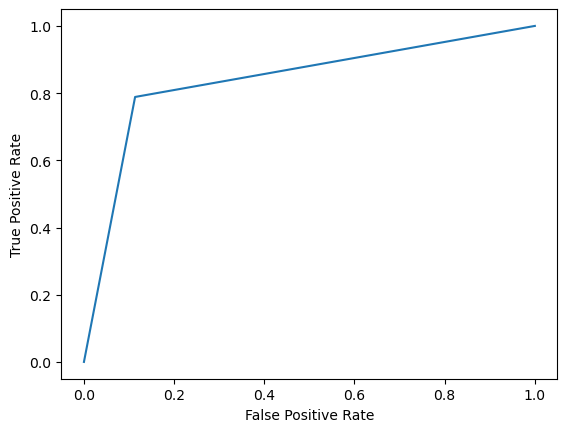

AUC Score: 0.8375722861825226


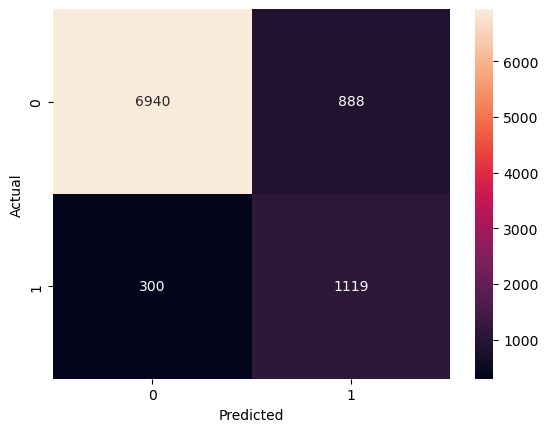

Large gap in score means overfitting: 
0.9557387057387058
0.8715259002919866


In [18]:
model = Group3Models.model_adaboost_V1(X_train_bal, y_train_bal)
Group3Models.evaluate_model(model, X_train_bal, X_test, y_train_bal, y_test)

#### ADABoost_V2

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.1, n_estimators=50;, score=0.875 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=50;, score=0.877 total time=   0.0s
[CV 3/5] END learning_rate=0.1, n_estimators=50;, score=0.911 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=50;, score=0.896 total time=   0.0s
[CV 5/5] END learning_rate=0.1, n_estimators=50;, score=0.888 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=100;, score=0.877 total time=   0.1s
[CV 2/5] END learning_rate=0.1, n_estimators=100;, score=0.875 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=100;, score=0.909 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=100;, score=0.904 total time=   0.1s
[CV 5/5] END learning_rate=0.1, n_estimators=100;, score=0.894 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=200;, score=0.883 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=200;, score=0.875 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=200;, score=0.914 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=200;, score=0.907 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=200;, score=0.890 total time=   0.3s
[CV 1/5] END learning_rate=0.5, n_estimators=50;, score=0.883 total time=   0.0s
[CV 2/5] END learning_rate=0.5, n_estimators=50;, score=0.874 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=50;, score=0.911 total time=   0.0s
[CV 4/5] END learning_rate=0.5, n_estimators=50;, score=0.896 total time=   0.0s
[CV 5/5] END learning_rate=0.5, n_estimators=50;, score=0.885 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=100;, score=0.882 total time=   0.1s
[CV 2/5] END learning_rate=0.5, n_estimators=100;, score=0.874 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=100;, score=0.903 total time=   0.1s
[CV 4/5] END learning_rate=0.5, n_estimators=100;, score=0.891 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=100;, score=0.885 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=200;, score=0.883 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=200;, score=0.875 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=200;, score=0.900 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=200;, score=0.893 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=200;, score=0.886 total time=   0.3s
[CV 1/5] END ..learning_rate=1, n_estimators=50;, score=0.882 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END ..learning_rate=1, n_estimators=50;, score=0.878 total time=   0.0s
[CV 3/5] END ..learning_rate=1, n_estimators=50;, score=0.896 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END ..learning_rate=1, n_estimators=50;, score=0.893 total time=   0.0s
[CV 5/5] END ..learning_rate=1, n_estimators=50;, score=0.878 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END .learning_rate=1, n_estimators=100;, score=0.878 total time=   0.1s
[CV 2/5] END .learning_rate=1, n_estimators=100;, score=0.880 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END .learning_rate=1, n_estimators=100;, score=0.896 total time=   0.1s
[CV 4/5] END .learning_rate=1, n_estimators=100;, score=0.880 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END .learning_rate=1, n_estimators=100;, score=0.881 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END .learning_rate=1, n_estimators=200;, score=0.878 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END .learning_rate=1, n_estimators=200;, score=0.882 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END .learning_rate=1, n_estimators=200;, score=0.891 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END .learning_rate=1, n_estimators=200;, score=0.883 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END .learning_rate=1, n_estimators=200;, score=0.880 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 200}
Best score found:  0.8939374644804143
Accuracy Score: 0.8929382502433222
Balanced Accuracy Score: 0.7648268822675544
              precision    recall  f1-score   support

       False       0.93      0.95      0.94      7828
        True       0.68      0.58      0.62      1419

    accuracy                           0.89      9247
   macro avg       0.80      0.76      0.78      9247
weighted avg       0.89      0.89      0.89      9247



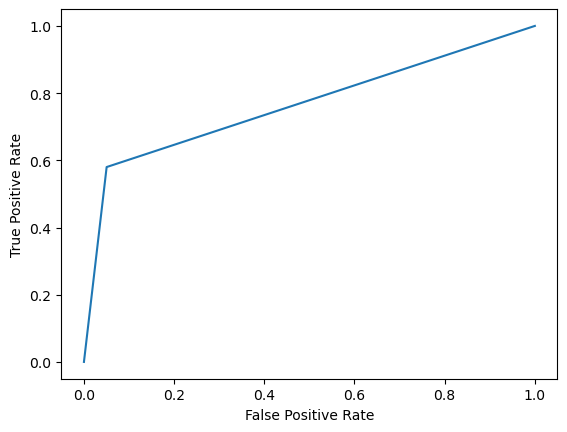

AUC Score: 0.7648268822675545


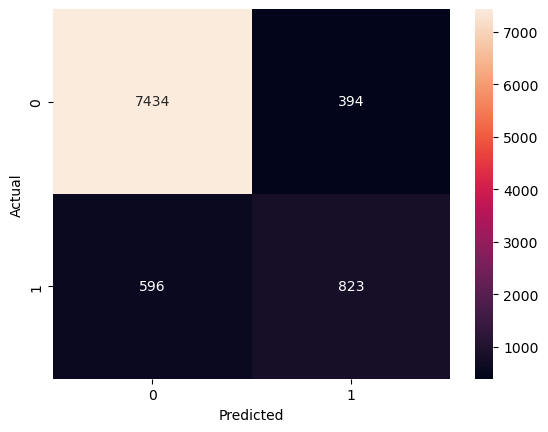

Large gap in score means overfitting: 
0.8984755108660396
0.8929382502433222


In [19]:
#Without SMOTEEN
model = Group3Models.model_adaboost_V2(X_train, y_train)
Group3Models.evaluate_model(model, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.1, n_estimators=50;, score=0.878 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=50;, score=0.959 total time=   0.0s
[CV 3/5] END learning_rate=0.1, n_estimators=50;, score=0.960 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=50;, score=0.931 total time=   0.0s
[CV 5/5] END learning_rate=0.1, n_estimators=50;, score=0.953 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=100;, score=0.877 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=100;, score=0.966 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=100;, score=0.962 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=100;, score=0.942 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=100;, score=0.960 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=200;, score=0.875 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=200;, score=0.966 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=200;, score=0.968 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=200;, score=0.954 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=200;, score=0.965 total time=   0.4s
[CV 1/5] END learning_rate=0.5, n_estimators=50;, score=0.872 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=50;, score=0.973 total time=   0.0s
[CV 3/5] END learning_rate=0.5, n_estimators=50;, score=0.969 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=50;, score=0.957 total time=   0.0s
[CV 5/5] END learning_rate=0.5, n_estimators=50;, score=0.966 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=100;, score=0.832 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=100;, score=0.973 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=100;, score=0.971 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=100;, score=0.963 total time=   0.2s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=100;, score=0.969 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=200;, score=0.802 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=200;, score=0.973 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=200;, score=0.968 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=200;, score=0.965 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=200;, score=0.973 total time=   0.4s
[CV 1/5] END ..learning_rate=1, n_estimators=50;, score=0.817 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END ..learning_rate=1, n_estimators=50;, score=0.968 total time=   0.0s
[CV 3/5] END ..learning_rate=1, n_estimators=50;, score=0.968 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END ..learning_rate=1, n_estimators=50;, score=0.960 total time=   0.0s
[CV 5/5] END ..learning_rate=1, n_estimators=50;, score=0.969 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END .learning_rate=1, n_estimators=100;, score=0.793 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END .learning_rate=1, n_estimators=100;, score=0.971 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END .learning_rate=1, n_estimators=100;, score=0.971 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END .learning_rate=1, n_estimators=100;, score=0.960 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END .learning_rate=1, n_estimators=100;, score=0.974 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END .learning_rate=1, n_estimators=200;, score=0.791 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END .learning_rate=1, n_estimators=200;, score=0.973 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END .learning_rate=1, n_estimators=200;, score=0.971 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END .learning_rate=1, n_estimators=200;, score=0.968 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END .learning_rate=1, n_estimators=200;, score=0.974 total time=   0.4s
Best parameters found:  {'learning_rate': 0.5, 'n_estimators': 50}
Best score found:  0.9475200148948055
Accuracy Score: 0.8697956093868282
Balanced Accuracy Score: 0.8457819151215547
              precision    recall  f1-score   support

       False       0.96      0.88      0.92      7828
        True       0.55      0.81      0.66      1419

    accuracy                           0.87      9247
   macro avg       0.76      0.85      0.79      9247
weighted avg       0.90      0.87      0.88      9247



c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


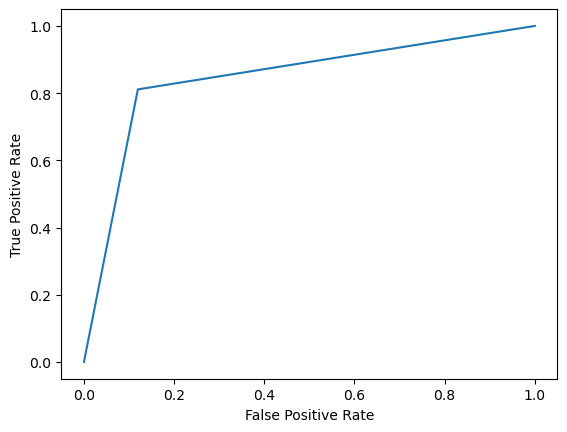

AUC Score: 0.8457819151215547


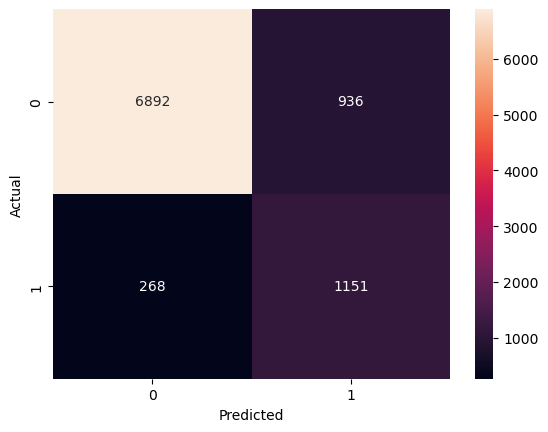

Large gap in score means overfitting: 
0.953907203907204
0.8697956093868282


In [20]:
model = Group3Models.model_adaboost_V2(X_train_bal, y_train_bal)
Group3Models.evaluate_model(model, X_train_bal, X_test, y_train_bal, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.1, n_estimators=50;, score=0.875 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=50;, score=0.877 total time=   0.0s
[CV 3/5] END learning_rate=0.1, n_estimators=50;, score=0.911 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=50;, score=0.896 total time=   0.0s
[CV 5/5] END learning_rate=0.1, n_estimators=50;, score=0.888 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=100;, score=0.877 total time=   0.1s
[CV 2/5] END learning_rate=0.1, n_estimators=100;, score=0.875 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=100;, score=0.909 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=100;, score=0.904 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=100;, score=0.894 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=200;, score=0.883 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=200;, score=0.875 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=200;, score=0.914 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=200;, score=0.907 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=200;, score=0.890 total time=   0.3s
[CV 1/5] END learning_rate=0.5, n_estimators=50;, score=0.883 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=50;, score=0.874 total time=   0.0s
[CV 3/5] END learning_rate=0.5, n_estimators=50;, score=0.911 total time=   0.0s
[CV 4/5] END learning_rate=0.5, n_estimators=50;, score=0.896 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=50;, score=0.885 total time=   0.0s
[CV 1/5] END learning_rate=0.5, n_estimators=100;, score=0.882 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=100;, score=0.874 total time=   0.1s
[CV 3/5] END learning_rate=0.5, n_estimators=100;, score=0.903 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=100;, score=0.891 total time=   0.1s
[CV 5/5] END learning_rate=0.5, n_estimators=100;, score=0.885 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=200;, score=0.883 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=200;, score=0.875 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=200;, score=0.900 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=200;, score=0.893 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=200;, score=0.886 total time=   0.3s
[CV 1/5] END ..learning_rate=1, n_estimators=50;, score=0.882 total time=   0.0s
[CV 2/5] END ..learning_rate=1, n_estimators=50;, score=0.878 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END ..learning_rate=1, n_estimators=50;, score=0.896 total time=   0.0s
[CV 4/5] END ..learning_rate=1, n_estimators=50;, score=0.893 total time=   0.0s
[CV 5/5] END ..learning_rate=1, n_estimators=50;, score=0.878 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END .learning_rate=1, n_estimators=100;, score=0.878 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END .learning_rate=1, n_estimators=100;, score=0.880 total time=   0.1s
[CV 3/5] END .learning_rate=1, n_estimators=100;, score=0.896 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END .learning_rate=1, n_estimators=100;, score=0.880 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END .learning_rate=1, n_estimators=100;, score=0.881 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END .learning_rate=1, n_estimators=200;, score=0.878 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END .learning_rate=1, n_estimators=200;, score=0.882 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END .learning_rate=1, n_estimators=200;, score=0.891 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END .learning_rate=1, n_estimators=200;, score=0.883 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END .learning_rate=1, n_estimators=200;, score=0.880 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best parameters found:  {'n_estimators': 200, 'learning_rate': 0.1}
Best score found:  0.8939374644804143
Accuracy Score: 0.8929382502433222
Balanced Accuracy Score: 0.7648268822675544
              precision    recall  f1-score   support

       False       0.93      0.95      0.94      7828
        True       0.68      0.58      0.62      1419

    accuracy                           0.89      9247
   macro avg       0.80      0.76      0.78      9247
weighted avg       0.89      0.89      0.89      9247



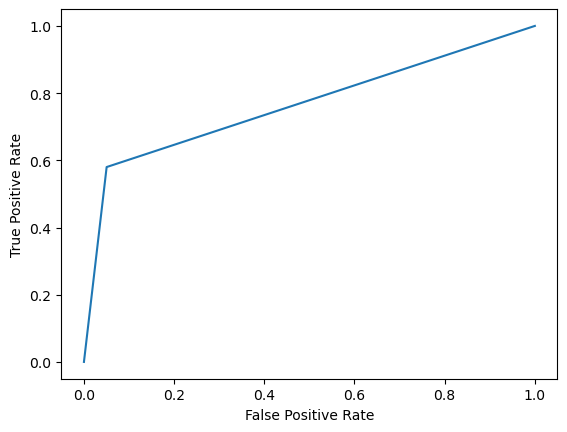

AUC Score: 0.7648268822675545


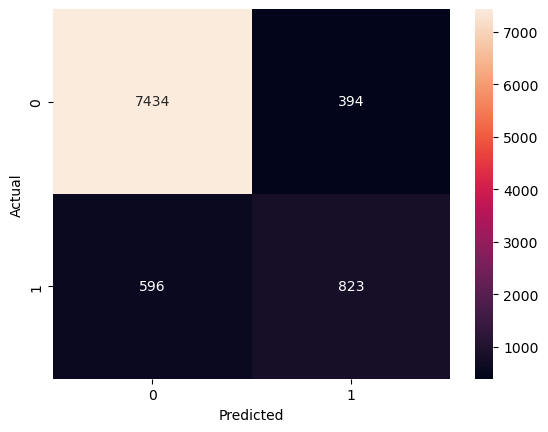

Large gap in score means overfitting: 
0.8984755108660396
0.8929382502433222


In [21]:
#Without SMOTEEN
model = Group3Models.model_adaboost_V3(X_train, y_train)
Group3Models.evaluate_model(model, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=50;, score=0.878 total time=   0.0s
[CV 2/5] END learning_rate=0.1, n_estimators=50;, score=0.959 total time=   0.0s
[CV 3/5] END learning_rate=0.1, n_estimators=50;, score=0.960 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=50;, score=0.931 total time=   0.0s
[CV 5/5] END learning_rate=0.1, n_estimators=50;, score=0.953 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=100;, score=0.877 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=100;, score=0.966 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=100;, score=0.962 total time=   0.2s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=100;, score=0.942 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=100;, score=0.960 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=200;, score=0.875 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=200;, score=0.966 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=200;, score=0.968 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=200;, score=0.954 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=200;, score=0.965 total time=   0.4s
[CV 1/5] END learning_rate=0.5, n_estimators=50;, score=0.872 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=50;, score=0.973 total time=   0.0s
[CV 3/5] END learning_rate=0.5, n_estimators=50;, score=0.969 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=50;, score=0.957 total time=   0.0s
[CV 5/5] END learning_rate=0.5, n_estimators=50;, score=0.966 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=100;, score=0.832 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=100;, score=0.973 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=100;, score=0.971 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=100;, score=0.963 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=100;, score=0.969 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=200;, score=0.802 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=200;, score=0.973 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=200;, score=0.968 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=200;, score=0.965 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=200;, score=0.973 total time=   0.4s
[CV 1/5] END ..learning_rate=1, n_estimators=50;, score=0.817 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END ..learning_rate=1, n_estimators=50;, score=0.968 total time=   0.0s
[CV 3/5] END ..learning_rate=1, n_estimators=50;, score=0.968 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END ..learning_rate=1, n_estimators=50;, score=0.960 total time=   0.0s
[CV 5/5] END ..learning_rate=1, n_estimators=50;, score=0.969 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END .learning_rate=1, n_estimators=100;, score=0.793 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END .learning_rate=1, n_estimators=100;, score=0.971 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END .learning_rate=1, n_estimators=100;, score=0.971 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END .learning_rate=1, n_estimators=100;, score=0.960 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END .learning_rate=1, n_estimators=100;, score=0.974 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END .learning_rate=1, n_estimators=200;, score=0.791 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END .learning_rate=1, n_estimators=200;, score=0.973 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END .learning_rate=1, n_estimators=200;, score=0.971 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END .learning_rate=1, n_estimators=200;, score=0.968 total time=   0.4s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END .learning_rate=1, n_estimators=200;, score=0.974 total time=   0.4s
Best parameters found:  {'n_estimators': 50, 'learning_rate': 0.5}
Best score found:  0.9475200148948055
Accuracy Score: 0.8697956093868282
Balanced Accuracy Score: 0.8457819151215547
              precision    recall  f1-score   support

       False       0.96      0.88      0.92      7828
        True       0.55      0.81      0.66      1419

    accuracy                           0.87      9247
   macro avg       0.76      0.85      0.79      9247
weighted avg       0.90      0.87      0.88      9247



c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


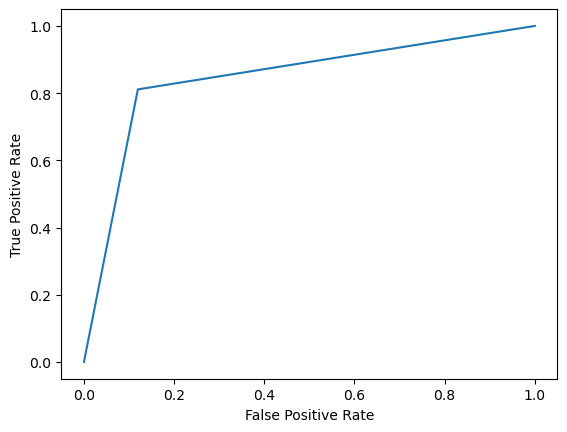

AUC Score: 0.8457819151215547


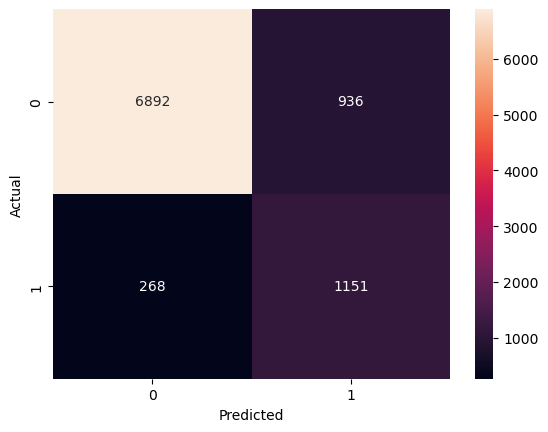

Large gap in score means overfitting: 
0.953907203907204
0.8697956093868282


In [22]:
model = Group3Models.model_adaboost_V3(X_train_bal, y_train_bal)
Group3Models.evaluate_model(model, X_train_bal, X_test, y_train_bal, y_test)

#### Logistic Regression

Best Parameters: 
{'C': 10, 'solver': 'lbfgs'}
Accuracy Score: 0.8925056775170326
Balanced Accuracy Score: 0.7112011938855946
              precision    recall  f1-score   support

       False       0.91      0.97      0.94      7828
        True       0.75      0.45      0.56      1419

    accuracy                           0.89      9247
   macro avg       0.83      0.71      0.75      9247
weighted avg       0.88      0.89      0.88      9247



c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


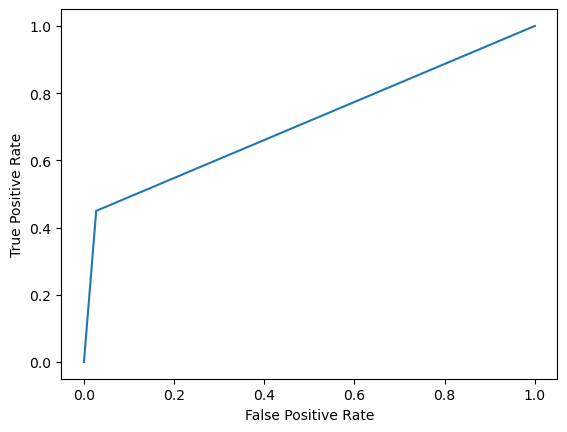

AUC Score: 0.7112011938855946


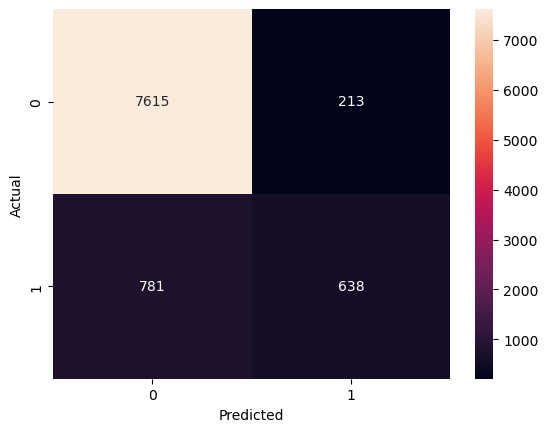

Large gap in score means overfitting: 
0.8809601037950049
0.8925056775170326


In [23]:
#without SMOTEENN
model = Group3Models.model_logistic_regression_v1(X_train, y_train)
Group3Models.evaluate_model(model, X_train, X_test, y_train, y_test)

Best Parameters: 
{'C': 100, 'solver': 'liblinear'}
Accuracy Score: 0.8667676003028009
Balanced Accuracy Score: 0.8096634459051424
              precision    recall  f1-score   support

       False       0.95      0.89      0.92      7828
        True       0.55      0.73      0.63      1419

    accuracy                           0.87      9247
   macro avg       0.75      0.81      0.77      9247
weighted avg       0.89      0.87      0.87      9247



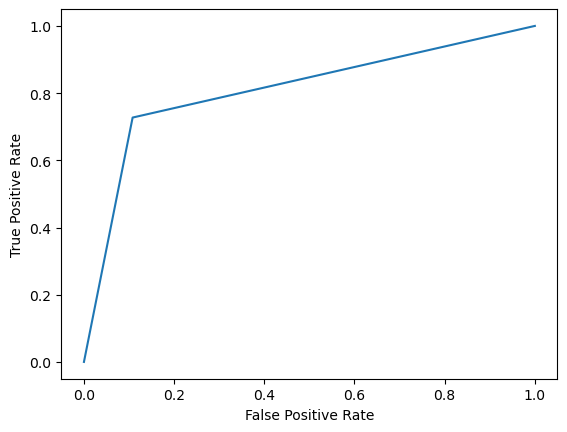

AUC Score: 0.8096634459051424


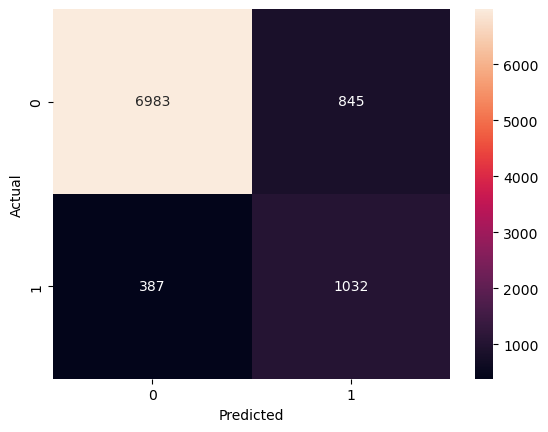

Large gap in score means overfitting: 
0.9468864468864469
0.8667676003028009


In [24]:
model = Group3Models.model_logistic_regression_v1(X_train_bal, y_train_bal)
Group3Models.evaluate_model(model, X_train_bal, X_test, y_train_bal, y_test)

In [25]:
#Drop the target column, setup X and y datasets for train test split
X = online_shopping_df.drop('Revenue', axis=1)
y = online_shopping_df['Revenue']

X.head()

#Train Test Split
X_test, X_train, y_test, y_train = train_test_split(X, y)
X_train.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000
mean,2.359715,80.810842,0.546221,39.854291,32.254946,1214.619803,0.022039,0.042495,6.043798,0.060915,2.129744,2.378527,3.201752,4.125203
std,3.366827,172.126579,1.347741,156.778836,44.975239,1831.345881,0.048065,0.047925,19.490118,0.196894,0.920617,1.784938,2.421949,4.102818
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,8.000000,192.250000,0.000000,0.014289,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,604.000000,0.003312,0.025000,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.053333,0.000000,0.000000,39.000000,1524.874188,0.017032,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,2086.750000,16.000000,2195.300000,584.000000,27009.859430,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


## Add Encodings to Feature Columns

In [26]:
#Encode VisitorType Column
ordinal_encoder = OrdinalEncoder()
X_train['VisitorType'] = ordinal_encoder.fit_transform(X_train[['VisitorType']])

#Ordinal Encode the Month Column
ordinal_encoder = OrdinalEncoder(categories=[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']])
X_train['Month'] = ordinal_encoder.fit_transform(X_train[['Month']])
X_train.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
11681,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,10.0,1,1,5,2,2.0,False
7179,2,116.8,0,0.0,5,170.400000,0.000000,0.028571,88.068484,0.0,10.0,2,2,7,2,0.0,False
5111,8,274.5,0,0.0,129,5883.040509,0.003077,0.008736,0.000000,0.0,4.0,1,1,6,2,2.0,False
6803,5,69.9,0,0.0,62,1846.666667,0.006061,0.018939,0.000000,0.0,7.0,2,2,1,3,2.0,False
1412,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2.0,2,4,3,1,2.0,False


In [27]:
#Encode VisitorType Column
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_test[['VisitorType']])
X_test['VisitorType'] = ordinal_encoder.transform(X_test[['VisitorType']])

#Ordinal Encode the Month Column
ordinal_encoder = OrdinalEncoder(categories=[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']])
X_test['Month'] = ordinal_encoder.fit_transform(X_test[['Month']])

<Axes: >

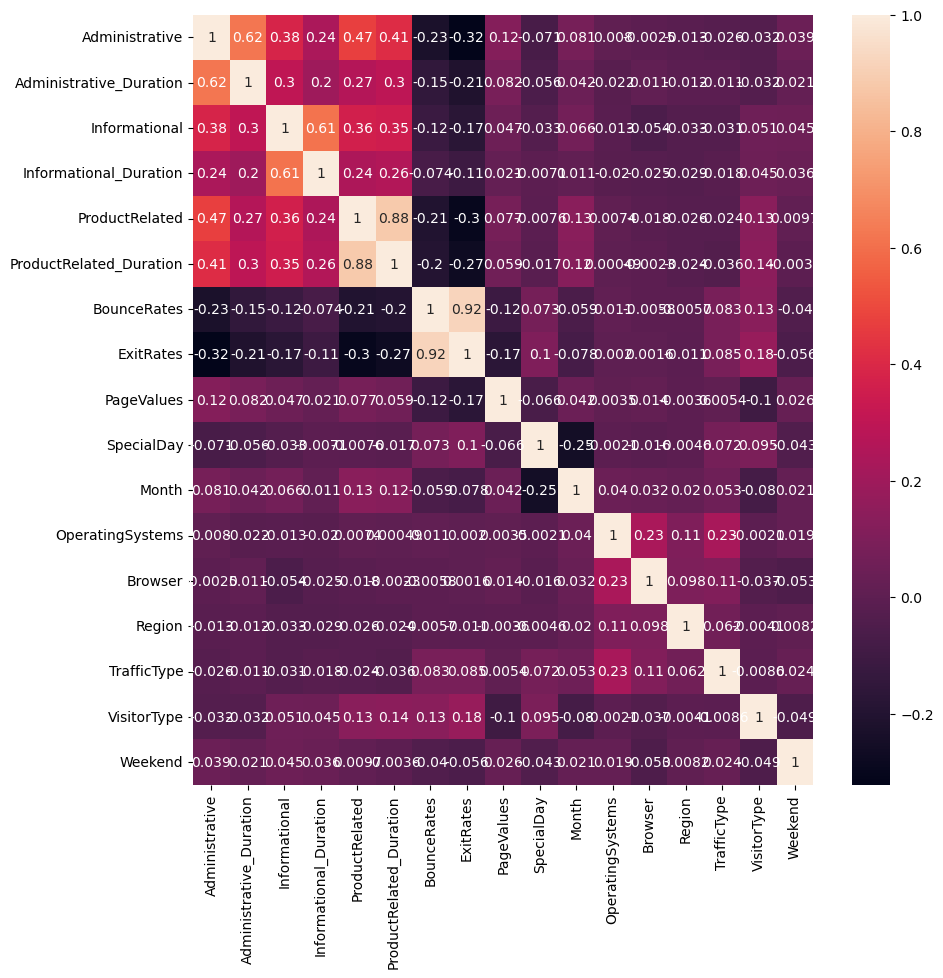

In [28]:
plt.figure(figsize=(10, 10))
sns.heatmap(data=X_train.corr(), annot=True)

## Create a Model and predict

Best Parameters: 
{'C': 0.1, 'solver': 'lbfgs'}
Accuracy Score: 0.8838542229912404
Balanced Accuracy Score: 0.6842792932215479
              precision    recall  f1-score   support

       False       0.90      0.97      0.93      7822
        True       0.73      0.40      0.51      1425

    accuracy                           0.88      9247
   macro avg       0.81      0.68      0.72      9247
weighted avg       0.87      0.88      0.87      9247



c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


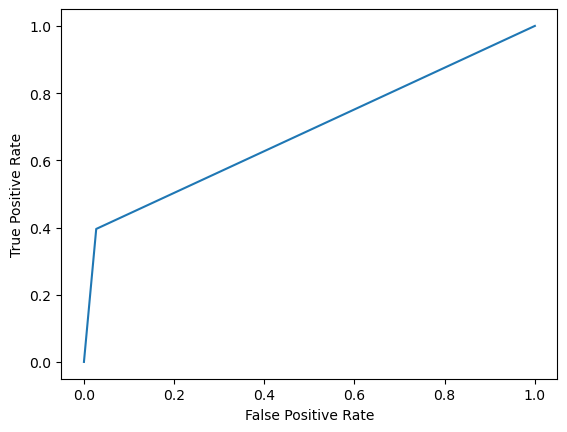

AUC Score: 0.6842792932215478


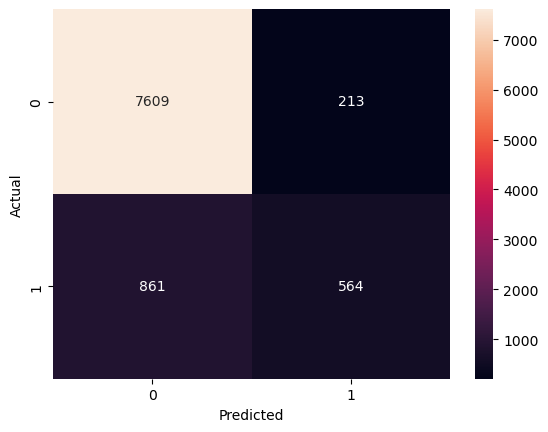

Large gap in score means overfitting: 
0.8864742134284788
0.8838542229912404


In [29]:
#without SMOTEENN
model = Group3Models.model_logistic_regression_v2(X_train, y_train)
Group3Models.evaluate_model(model, X_train, X_test, y_train, y_test)

In [ ]:
Group3Models.export_model_evaluation(X_train, X_test, y_train, y_test, X_train_bal, y_train_bal)

NameError: name 'y_pred' is not defined

In [ ]:
# model = Group3Models.model_logistic_regression_v2(X_train_bal, y_train_bal)
# Group3Models.evaluate_model(model, X_train_bal, X_test, y_train_bal, y_test)

NameError: name 'X_train_bal' is not defined

#### Pipeline Logistic Regression

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalize data
    ('model', LogisticRegression())  # Train classifier
])

In [ ]:
pipeline.fit(X_train, y_train)
print("Test Accuracy train:", pipeline.score(X_train, y_train))
print("Test Accuracy test:", pipeline.score(X_test, y_test))
